# **MIDAS Task 1 - Data EDA and Loading**

For this task, two different methods are tested and evaluated. The methods differ mainly on the audio feature used for classification. They are listed below as:
1. Using Normalized Log Spectrogram of Audio Samples
2. Using MFCC's and their higher order Deltas

**This notebook only has Data Loading and EDA. Files were trained and tested on Colab for access to a larger RAM. That is shown in MIDAS_TASK1_TrainTest. This notebook has:**
* Libraries Required
* Data Check
* EDA
* Data Loading, Preprocessing 

References:

1. David S., Speech representation and Data Exploration: Has been used to better understand the data

## Libraries Installation

In [15]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import random
from os.path import isdir, join
import regex as re
import pickle

import librosa
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd 

import warnings
warnings.filterwarnings("ignore")

## Data Check

Labels for Prediction Task -> ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence'] (12)

Labels Given -> 31

In [2]:
'''
Check Training Audio Folder
'''

train_audio_path = 'Task1Data/train/audio/'
print(len(os.listdir(train_audio_path)))
print(os.listdir(train_audio_path))

31
['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


## Exploratory Data Analysis

In [3]:
'''
Loading a sample file to study
'''

# At 8000 
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples2, sample_rate2 = librosa.load(str(train_audio_path) + filename, 8000)

# At 16000 
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path) + filename, 16000)
print('Sample Rate: ', sample_rate)
print()
ipd.Audio(samples, rate=sample_rate)

Sample Rate:  16000



In [4]:
'''
HELPER FUNTIONS FOR PLOTTING AND DATA ANALYSIS
'''


'''
Defining a funtion to calculate LOG SPECTROGRAM
Module used -> SCIPY SIGNAL

Parameters:

window - Hamming window is used (Trend observed in multiple papers)
fs - Sample Rate (8000)
nperseg - Length of each sample segment
noverlap - Length of overlap of windows

Note that the spectrogram will also be normalized over its mean and standard deviation later.
'''

def log_spectrogram (audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hamming',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)



'''
Defining a funtion to calculate FFT
Reference - David S., Speech representation and Data Exploration

Module -Scipy FFT

Notes:
1. FFT is simmetrical, so we take just the first half
2. FFT is also complex, to we take just the real part (abs)
'''

def fft_self(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2]) 
    return xf, vals

##### Plotting Spectrogram of Single Sample

Text(0.5, 0, 'Seconds')

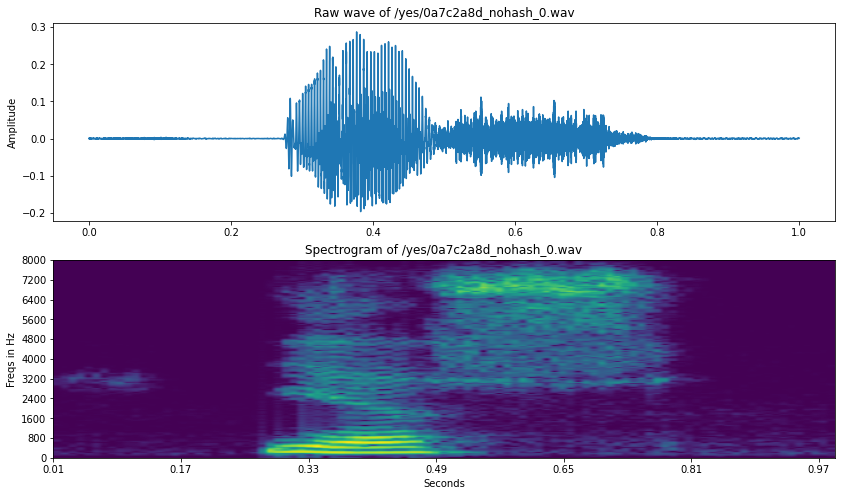

In [5]:
freqs, times, spectrogram = log_spectrogram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

##### Plotting MFCCs of Single Sample

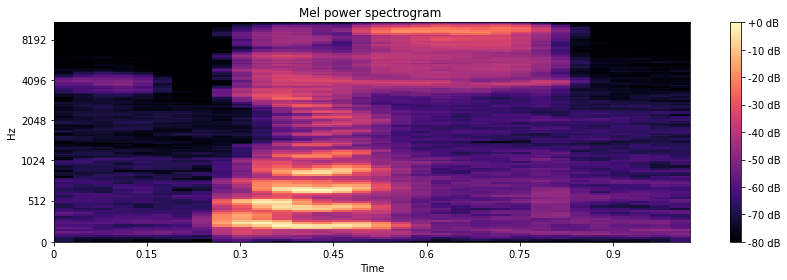

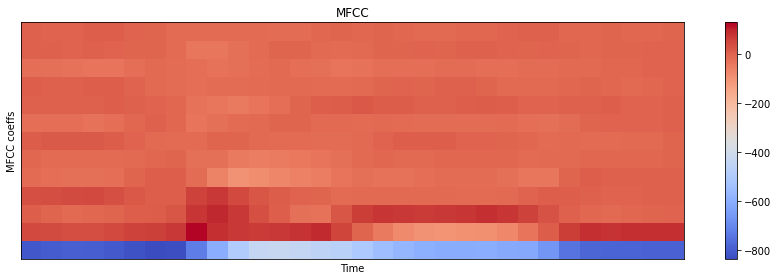

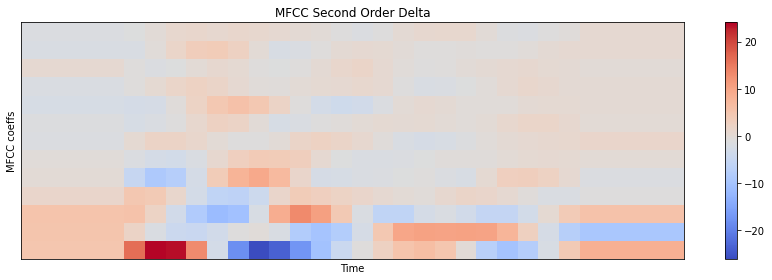

In [6]:
'''
Using Librosa to plot mel scaled power spectrogram and MFCCs of signals

1. First the Power Spectrogram is shown.
2. Then the MFCC of the same is shown.
'''

S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB).
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

'''
Also Plotting Second Order Delta MFCCs
'''

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC Second Order Delta')
plt.colorbar()
plt.tight_layout()

##### FFTs at 16000 and 8000 Sampling Rate

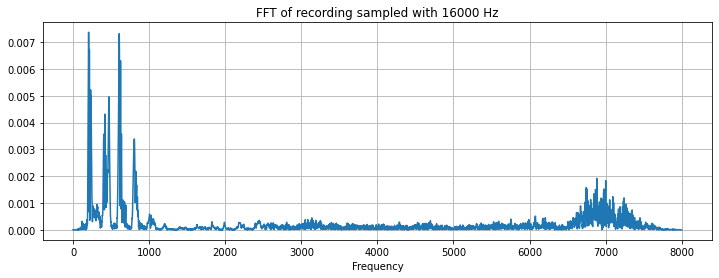

In [7]:
'''
Sampling Rate - 16000 Hz
'''

xf, vals = fft_self(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

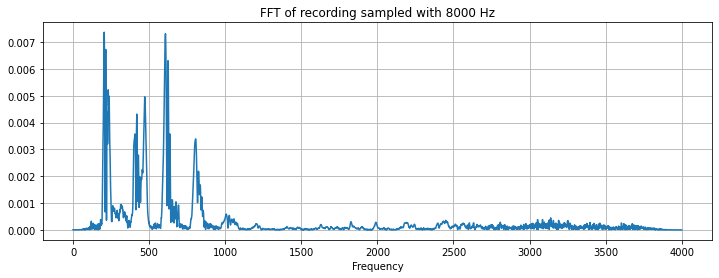

In [8]:
'''
Sampling Rate - 8000 Hz
'''

xf, vals = fft_self(samples2, sample_rate2)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate2) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

##### Mean FFTs and Spectrograms of all classes

*Reference - David S., Speech representation and Data Exploration*

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


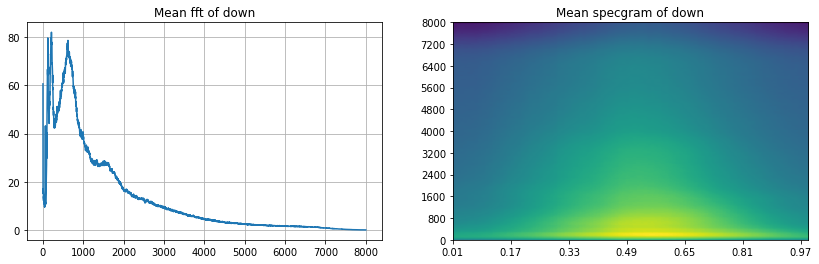

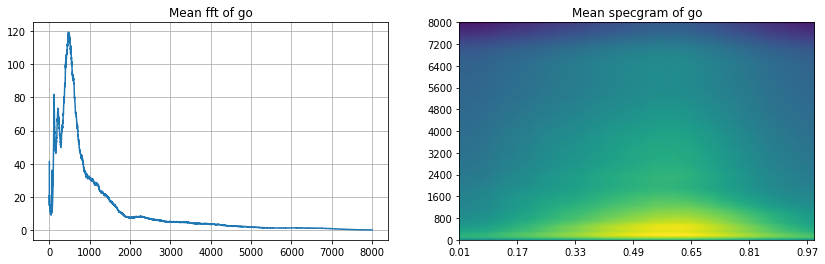

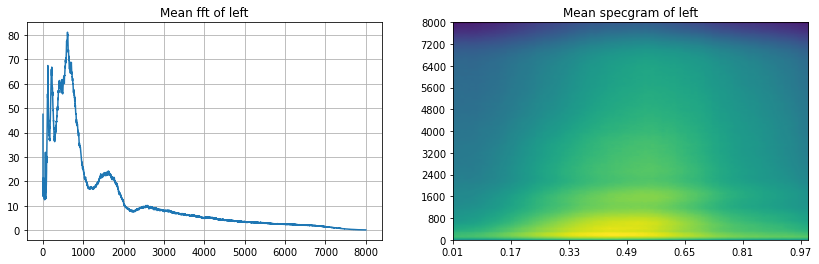

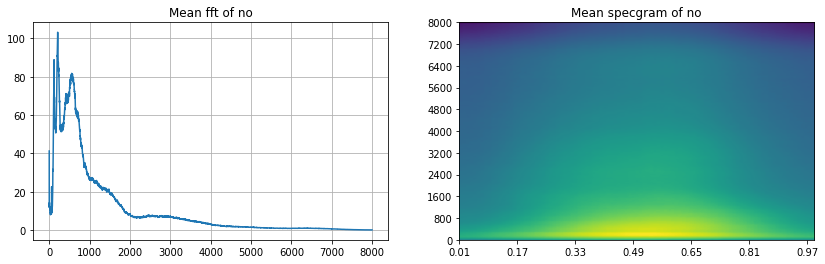

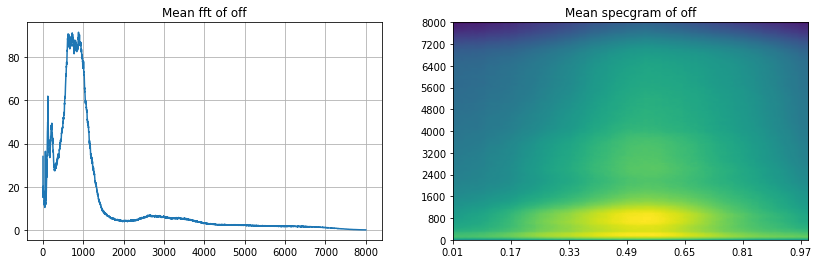

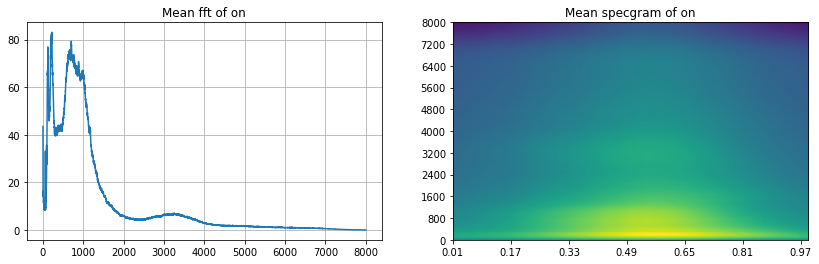

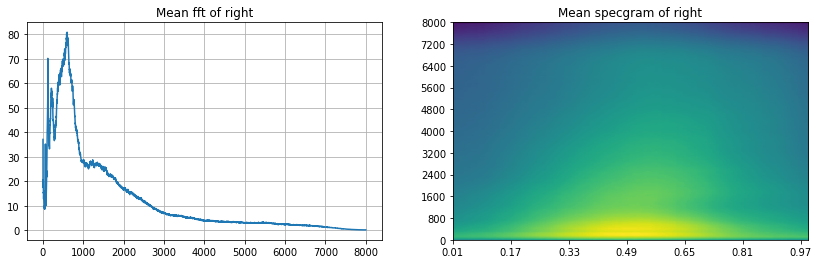

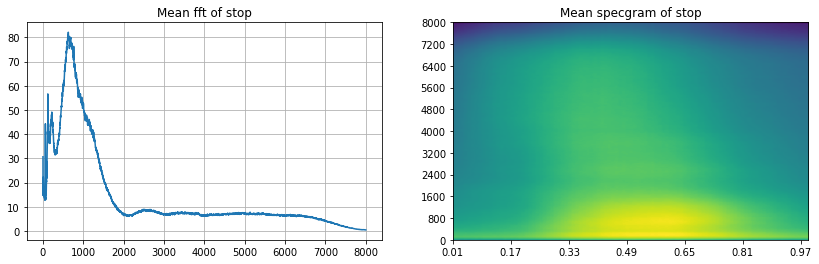

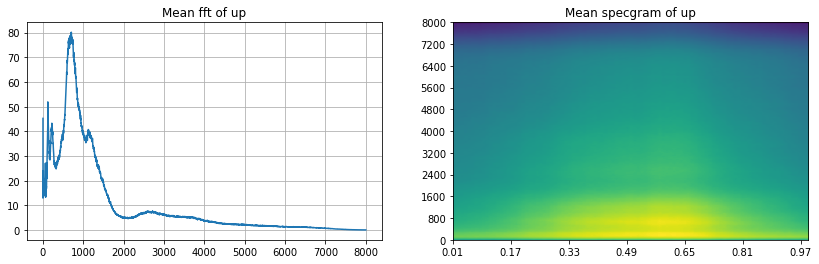

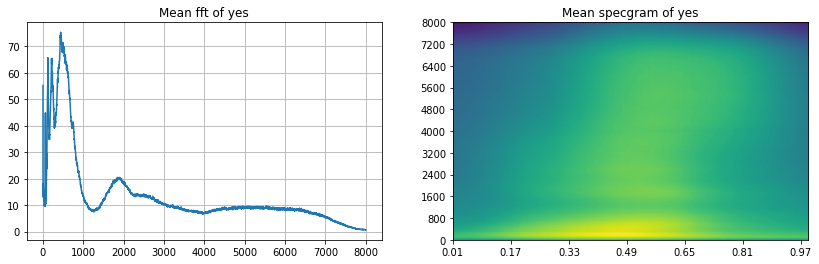

In [9]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = fft_self(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_spectrogram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

## Data Loading, Preprocessing and Feature Extraction

##### Details:

1. All files are sampled at 16000 HZ
2. The file length has been kept constant at 1 second.
2. Zero Padding has been used in sound processing to make audio files of same length. The same has been implemented here.
3. For extremely long audio files, they have been split into smaller 1 second samples.

##### Features

1. Log Spectrograms are loaded for each audio sample.
2. These are all of the same shape since data is padded to same size.
3. They are normalized over the entire dataset.

#### Data Loading

In [10]:
'''
Variables to load data.

sr - Sample Rate
Legal Labels - Categories to Classify
'''

sr = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

# Paths
train_data_path = 'Task1Data/train/audio'
test_data_path = 'Task1Data/test'

# Path Helper
ext = 'wav'

#### Defining Helpers To Load Data

In [11]:
'''
Utility Function

Task - Collect all file names.
'''

def collect_files(path):
    
    # Simple Regex to collect paths
    fpaths = glob(os.path.join(path, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    
    labels = []
    for fpath in fpaths:
        fpath = fpath.replace('\\', '/')
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        fpath = fpath.replace('\\', '/')
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [12]:
'''
Padding -> Pad smaller samples with 0

Reduce -> Reduce audio to predefined size.

Labellize -> Tranform label to suitable format for model.
'''

def padding(samples):
    if len(samples) >= sr: 
        return samples
    else: 
        return np.pad(samples, pad_width=(sr - len(samples), 0), mode='constant', constant_values=(0, 0))

def reduce(samples, sr=16000, num=20):
    for i in range(num):
        cut = np.random.randint(0, len(samples) - sr)
        yield samples[cut: cut + sr]

def labellize(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

#### Creating Data

In [13]:
'''
Get paths and labels.
'''

labels, filenames = collect_files(train_data_path)

Y_tr = []
X_tr = []

In [14]:
'''
Load Log Specs
'''

for label, fname in tqdm(zip(labels, filenames)):
    
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = padding(samples)
    if len(samples) > 16000:
        n_samples = reduce(samples)
    else: 
        n_samples = [samples]
    for samples in n_samples:
        _, _, specgram = log_spectrogram(samples, sample_rate=sr)
        Y_tr.append(label)
        X_tr.append(specgram)

64727it [30:47, 35.03it/s] 


In [ ]:
'''
Storing Data as Pickle File To Upload and Run On Colab (Due to RAM limitations).
'''

with open("train_x.txt", "wb") as fp:
    pickle.dump(X_tr, fp)
    
with open("train_y.txt", "wb") as fp:
    pickle.dump(Y_tr, fp)